$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$
# Part 4: Fine-Tuning a pretrained language model
<a id=part3></a>

In this part , we will deal with the fine-tuning of BERT for sentiment analysis on the IMDB movie reivews dataset from the previous section.   
BERT is a large language model developed by Google researchers in 2019 that offers a good balance between popularity and model size, which can be fine-tuned using a simple GPU.  

If you aren't yet familiar, you can check it out here:  
https://arxiv.org/pdf/1810.04805.pdf.
(Read Section 3 for details on the model architecture and fine-tuning on downstream tasks).

In particular, we will use the distilled (smaller) version of BERT, called Distil-BERT.
Distil-BERT is widely used in production since it has 40% fewer parameters than BERT, while running 60% faster and retaining 95% of the performance in many benchmarks.
It is recommended to glance through the Distil-BERT paper to get a feel for the model architecture and how it differs from BERT:
https://arxiv.org/pdf/1910.01108.pdf

We will download a pre-trained `Distil-BERT` from `Hugging Face`, so there is no need to train it from scratch.

One of the key strengths of Hugging Face is its extensive collection of pre-trained models. These models are trained on large-scale datasets and exhibit impressive performance on various NLP tasks, such as text classification, named entity recognition, sentiment analysis, machine translation, and question answering, among others. The pre-trained models provided by Hugging Face can be easily fine-tuned for specific downstream tasks, saving significant time and computational resources.  


In [2]:
import numpy as np
import pandas as pd
import torch
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re

import numpy as np
import torch
import matplotlib.pyplot as plt

import pickle


%load_ext autoreload
%autoreload 2

### Porting to Google Colab
The following cell enables this notebook to run from Google Colab as well as from your local machine IDE.<br>
You can change `root_directory` and/or `this_notebook_google_path` to point to the directory in your Google account, which contains this notebook, together with the `imgs` sub-directory and the rest of the files.<br>

In [3]:
import sys
import os
try:
    from google.colab import drive
    root_directory = '/content/gdrive/'
    this_notebook_google_path = root_directory + 'MyDrive/hw3'
    drive.mount(root_directory)
    # enable import python files from this notebook's path
    sys.path.append(this_notebook_google_path)
    # enable reading images and data files from this notebook's path
    os.chdir(this_notebook_google_path)
except:
    # no Google Colab --> fall back to local machine
    pass

Mounted at /content/gdrive/


In [4]:
!pip install pillow pillow-avif-plugin

import matplotlib.image as mpimg
from IPython import display
import PIL
import io

"""
The import of pillow_avif is necessary because it registers the AVIF format
with the Pillow library. This registration process occurs automatically when
pillow_avif is imported, enabling Pillow to recognize and handle AVIF images.
Without this import, Pillow won't be able to identify the AVIF format,
leading to the UnidentifiedImageError.
To clarify, you don't use pillow_avif directly in your code, but importing it
ensures that the AVIF support is correctly set up.
"""
import pillow_avif

def show_single_image(file_name: str, resize: float = 1.0) -> None:
    file_name_lower = file_name.lower()
    if file_name_lower.endswith('.gif'):
        if not os.path.isfile(file_name):
            print('Current directory is:',os.getcwd())
            print('Containing the following files:')
            for subdir, dirs, files in os.walk('./'):
                for file in files:
                    print(file)
            assert False, f'File not found: {file_name}'
        with open(file_name, 'rb') as f:
            img_data = f.read()
        img = display.Image(data=img_data, format='png')
        display.display(img)
    elif file_name_lower.endswith('.svg'):
        img = display.SVG(filename=file_name)
        display.display(img)
    elif file_name_lower.endswith('.avif') or file_name_lower.endswith('.png'):
        with open(file_name, 'rb') as f:
            img_data = f.read()
        img = PIL.Image.open(io.BytesIO(img_data))
        img = img.resize((img.width * resize, img.height * resize))
        display.display(img)
    else:
        image1 = mpimg.imread(file_name)
        fig, ax = plt.subplots()
        ax.set_title(file_name)
        plt.imshow(image1)
        plt.axis('off')  # Turn off axis
        plt.show()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 42.2 MB/s eta 0:00:00


In [5]:
!pip install datasets pyarrow==14.0.2 requests==2.31.0

from torch.utils.data import DataLoader, Dataset

import numpy as np
from datasets import DatasetDict
from datasets import load_dataset, load_metric, concatenate_datasets

from hw3 import training


from cs236781.plot import plot_fit
from cs236781.train_results import FitResult

## Loading the Dataset

We will now load and prepare the IMDB dataset as we did in the previous part.  
Here we will load the full training and test set.


In [6]:
dataset = load_dataset('imdb', split=['train', 'test[12260:12740]'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [7]:
print(dataset)

[Dataset({
    features: ['text', 'label'],
    num_rows: 25000
}), Dataset({
    features: ['text', 'label'],
    num_rows: 480
})]


In [8]:
#wrap it in a DatasetDict to enable methods such as map and format
dataset = DatasetDict({'train': dataset[0], 'test': dataset[1]})

In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 480
    })
})

We can now access the datasets in the Dict as we would a dictionary.
Let's print a few training samples

In [10]:
for i in range(4):
    print(f'TRAINING SAMPLE {i}:')
    print(dataset['train'][i]['text'])
    label = dataset['train'][i]['label']
    print(f'Label {i}: {label}')
    print('\n')

TRAINING SAMPLE 0:
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few a

We should also check the label distribution:

In [11]:
def label_cnt(type):
    ds = dataset[type]
    size = len(ds)
    cnt= 0
    for smp in ds:
        cnt += smp['label']
    print(f'negative samples in {type} dataset: {size - cnt}')
    print(f'positive samples in {type} dataset: {cnt}')

label_cnt('train')
label_cnt('test')

negative samples in train dataset: 12500
positive samples in train dataset: 12500
negative samples in test dataset: 240
positive samples in test dataset: 240


### __Import the tokenizer for the dataset__


We will now tokenize the text the same way we did in the previous part.



In [12]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
print("Tokenizer input max length:", tokenizer.model_max_length)
print("Tokenizer vocabulary size:", tokenizer.vocab_size)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizer input max length: 512
Tokenizer vocabulary size: 30522


In [13]:
def tokenize_text(batch):
    return tokenizer(batch["text"], truncation=True, padding=True)

def tokenize_dataset(dataset):
    dataset_tokenized = dataset.map(tokenize_text, batched=True, batch_size =None)
    return dataset_tokenized

dataset_tokenized = tokenize_dataset(dataset)
# we would like to work with pytorch so we can manually fine-tune
dataset_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])
# no need to parrarelize in this assignment
os.environ["TOKENIZERS_PARALLELISM"] = "false"

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/480 [00:00<?, ? examples/s]

### Setting up the dataloaders and dataset

We will now set up the dataloaders for efficient batching and loading of the data.  
By now, you are familiar with the Class methods that are needed to create a working Dataloader.


In [14]:
class IMDBDataset(Dataset):
    def __init__(self, dataset):
        self.ds = dataset

    def __getitem__(self, index):
        return self.ds[index]

    def __len__(self):
        return self.ds.num_rows

In [15]:
train_dataset = IMDBDataset(dataset_tokenized['train'])
test_dataset = IMDBDataset(dataset_tokenized['test'])

In [16]:

n_workers= 0

dl_train,dl_test = [
    DataLoader(
    dataset=train_dataset,
    batch_size=12,
    shuffle=True,
    num_workers=n_workers
),
DataLoader(
    dataset=test_dataset,
    batch_size=12,
    shuffle=False,
    num_workers=n_workers
)]

In [17]:
dl_train

## Importing the model from Hugging Face
We will now  delve into the process of loading the DistilBERT model from `Hugging Face`. DistilBERT is a distilled version of the BERT model, offering a lighter and faster alternative while retaining considerable performance on various NLP tasks.  
Please refer to the introduction to check out the relevant papers.  
For more info on how to use this model, feel free to check it out on the site:  
https://huggingface.co/distilbert-base-uncased



To begin, we will import the necessary library required for our implementation.
It is fine if you receive a warning from `Hugging Face` to train the model on a downstream task, which is exactly what we will do on our IMDB dataset.

In [18]:
from transformers import AutoModelForSequenceClassification


In [19]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


__Let's print the model architecture to see what we are dealing with:__

In [20]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

## Fine Tuning
We will now move on to the process of fine-tuning the model that we previously loaded from `Hugging Face`. Fine-tuning allows us to adapt the pre-trained model to our specific NLP task by further training it on task-specific data. This process enhances the model's performance and enables it to make more accurate predictions on our target task.  

There are generally two approaches to fine-tuning the loaded model, each with its own advantages and considerations:  

1) __Freeze all the weights besides the last two linear layers and train only those layers__:  
This approach is commonly referred to as "transfer learning" or "feature extraction." By freezing the weights of the majority of the model's layers, we retain the pre-trained knowledge captured by the model, allowing it to extract useful features from our data. We then replace and train the final few layers, typically linear layers, to adapt the model to our specific task. This method is beneficial when we have limited labeled data or when the pre-trained model has been trained on a similar domain.

2) __Retrain all the parameters in the model__:  
This approach involves unfreezing and training all the parameters of the loaded model, including the pre-trained layers. By retraining all the parameters, we allow the model to adjust its representations and update its knowledge based on our specific task and data. This method is often preferred when we have sufficient labeled data available and want the model to learn task-specific features from scratch or when the pre-trained model's knowledge may not be directly applicable to our domain.

### Fine-tuning method 1
__Freeze all the weights besides the last two linear layers and train only those layers__



In [21]:
# TODO:
# Freeze all parameters except for the last 2 linear layers
# HINT: use the printed model architecture to get the layer names

training.freeze_model_except_for_the_last_2_linear_layers(model)

### Training
We can use our abstract __Trainer__ class to fine-tune the model:
We will not play around with hyperparameters in this section, as the point is to learn to fine-tune a model.   
In addition, we do not need to send our own loss function for this loaded model (try to understand why).   

__TODO__: Implement the `FineTuningTrainer` in `hw3/training.py`

We will train the model for 2 epochs of 40 batches.  
You can run this either locally or on the course servers, whichever is most comfortable for you.

In [22]:
from hw3 import training

optimizer = torch.optim.Adam(model.parameters(), lr = 5e-5)

# fit your model
if not os.path.exists('finetuned_last_2.pt'):
    trainer = training.FineTuningTrainer(model, loss_fn = None, optimizer = optimizer)
    fit_result = trainer.fit(dl_train,dl_test, checkpoints='finetuned_last_2', num_epochs=2, max_batches= 40)
    with open('fit_result_finetune_2.pkl', 'wb') as f:
        pickle.dump(fit_result, f)


saved_state = torch.load('finetuned_last_2.pt')
model.load_state_dict(saved_state['model_state'])
best_acc = saved_state['best_acc']
print('best acc:', best_acc)

with open('fit_result_finetune_2.pkl', 'rb') as f:
    fit_result = pickle.load(f)



--- EPOCH 1/2 ---
test_batch (Avg. Loss 0.668, Accuracy 52.1): 100%|██████████| 40/40 [10:03<00:00, 15.09s/it]
*** Saved checkpoint finetuned_last_2.pt at epoch 1
--- EPOCH 2/2 ---
test_batch (Avg. Loss 0.637, Accuracy 80.2): 100%|██████████| 40/40 [10:12<00:00, 15.31s/it]
*** Saved checkpoint finetuned_last_2.pt at epoch 2
best acc: 80.20833333333333


(<Figure size 1600x1000 with 4 Axes>,
 array([<Axes: title={'center': 'train_loss'}, xlabel='Iteration #', ylabel='Loss'>,
        <Axes: title={'center': 'train_acc'}, xlabel='Epoch #', ylabel='Accuracy (%)'>,
        <Axes: title={'center': 'test_loss'}, xlabel='Iteration #', ylabel='Loss'>,
        <Axes: title={'center': 'test_acc'}, xlabel='Epoch #', ylabel='Accuracy (%)'>],
       dtype=object))

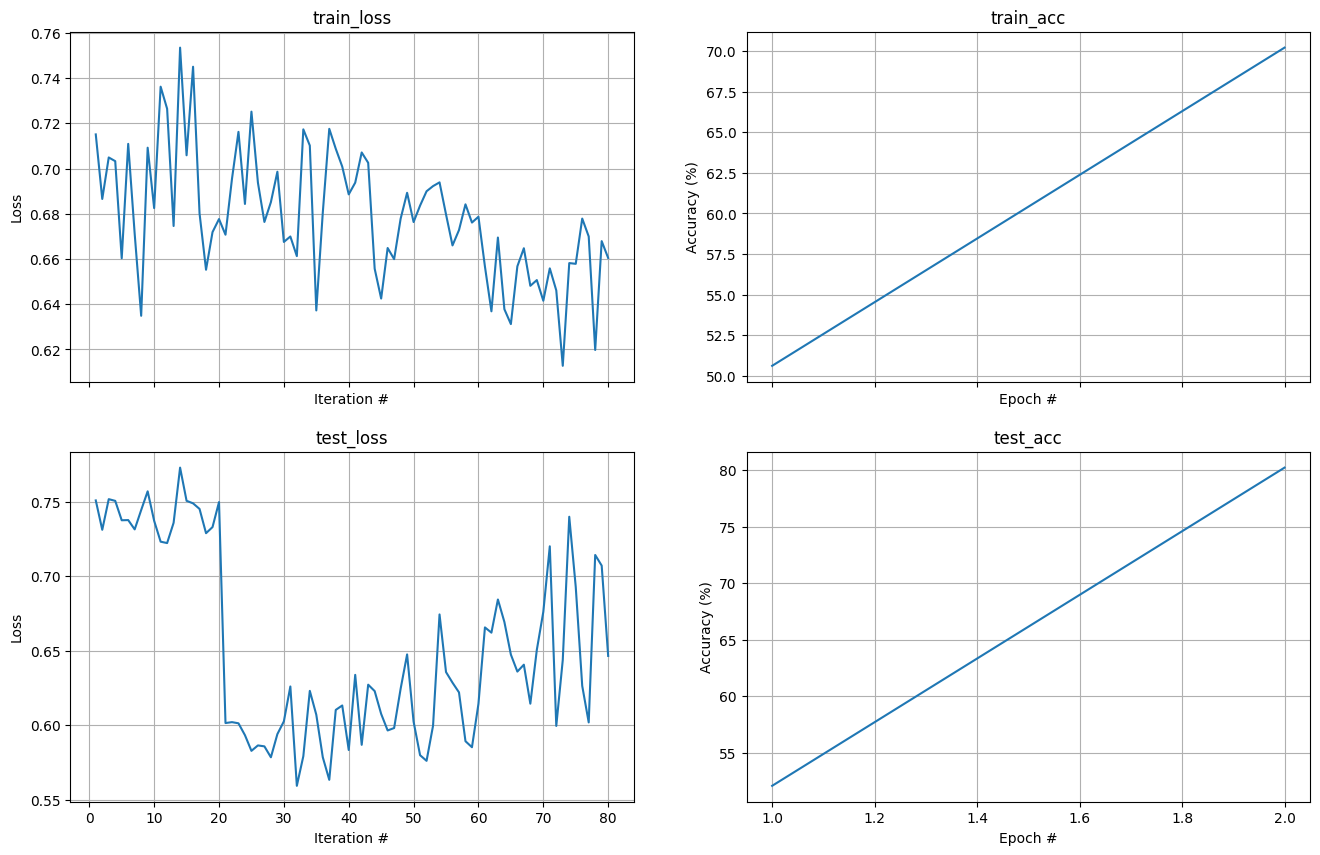

In [23]:
plot_fit(fit_result)

### Fine-tuning method 2
__Retraining all the parameters in the model__

We will reload the model to ensure that the parameters are untouched and we are starting from scratch

In [24]:
from transformers import AutoModelForSequenceClassification

In [25]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [27]:
# TODO: Make sure all the model parameters are unfrozen
training.unfreeze_all_model_parameters(model)

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr = 5e-5)

# fit your model
if not os.path.exists('finetuned_all.pt'):
    trainer = training.FineTuningTrainer(model, loss_fn = None, optimizer = optimizer)
    fit_result = trainer.fit(dl_train,dl_test, checkpoints='finetuned_all', num_epochs=2, max_batches= 40)
    with open('finetuned_all.pkl', 'wb') as f:
        pickle.dump(fit_result, f)


saved_state = torch.load('finetuned_all.pt')
model.load_state_dict(saved_state['model_state'])

with open('finetuned_all.pkl', 'rb') as f:
    fit_result = pickle.load(f)


--- EPOCH 1/2 ---
test_batch (Avg. Loss 0.351, Accuracy 85.0): 100%|██████████| 40/40 [07:57<00:00, 11.94s/it]
*** Saved checkpoint finetuned_all.pt at epoch 1
--- EPOCH 2/2 ---
test_batch (Avg. Loss 0.319, Accuracy 85.4): 100%|██████████| 40/40 [08:01<00:00, 12.03s/it]
*** Saved checkpoint finetuned_all.pt at epoch 2


(<Figure size 1600x1000 with 4 Axes>,
 array([<Axes: title={'center': 'train_loss'}, xlabel='Iteration #', ylabel='Loss'>,
        <Axes: title={'center': 'train_acc'}, xlabel='Epoch #', ylabel='Accuracy (%)'>,
        <Axes: title={'center': 'test_loss'}, xlabel='Iteration #', ylabel='Loss'>,
        <Axes: title={'center': 'test_acc'}, xlabel='Epoch #', ylabel='Accuracy (%)'>],
       dtype=object))

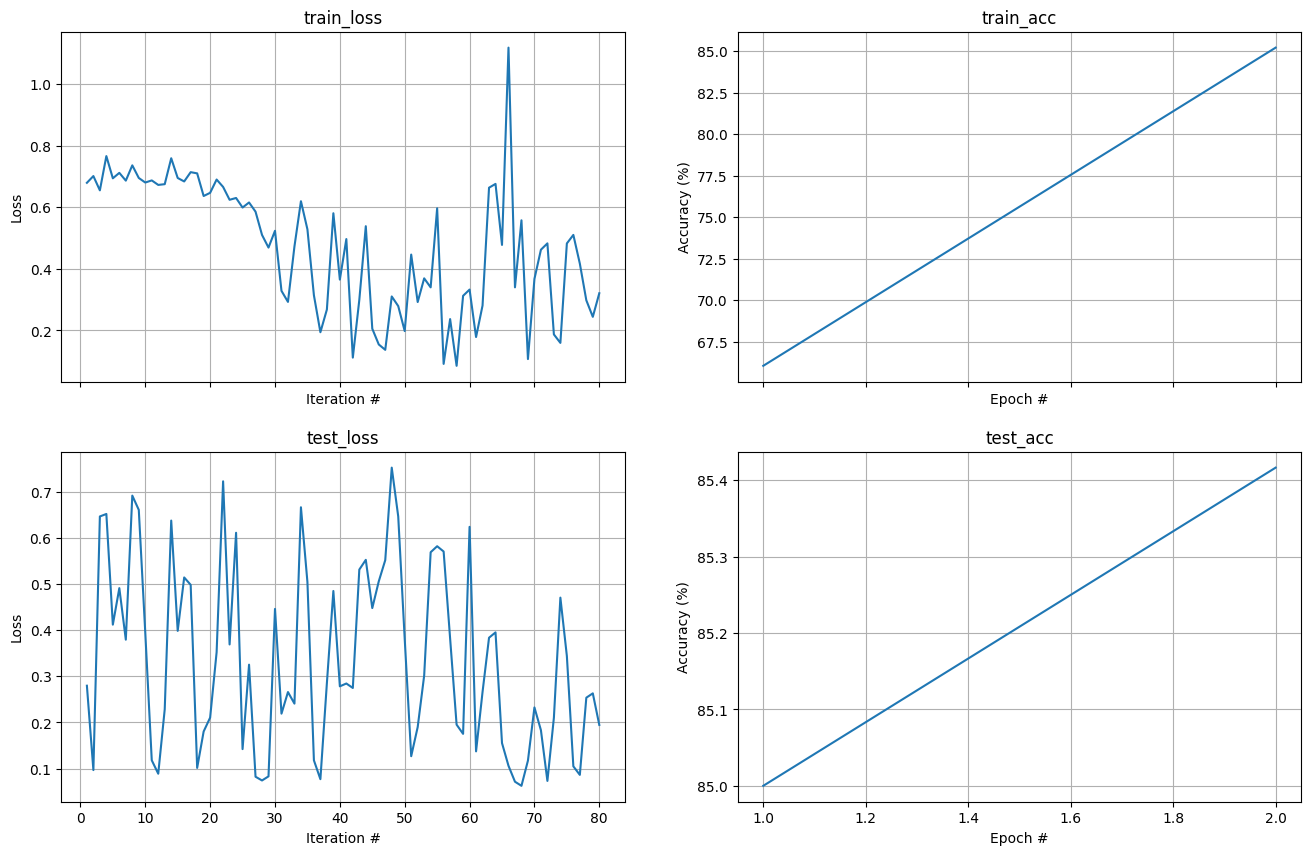

In [29]:
plot_fit(fit_result)

## Questions

Fill out your answers in `hw3.answers.part4_q1` and `hw3.answers.part4_q2`

In [1]:
from cs236781.answers import display_answer
import hw3.answers

### Question 1

Explain the results that you got here in comparison to the results achieved in the *trained from scratch* encoder from the preivous part.  
If one of the models performed better, why was this so?   
Will this always be the case on any downstream task, or was this phenomenom specific to this task?


In [2]:
display_answer(hw3.answers.part4_q1)



The fine-tuned DistilBERT models did better than the encoder we trained from scratch earlier. Method 2, where we retrained all parts of the model, got 86.9% accuracy, while Method 1, where we only trained the last few layers, got 65.4%. Both beat our custom encoder.
This happened because DistilBERT already knows a lot about language from its pre-training. When we fine-tune it, it can use this knowledge and adapt it to our specific task. It's like giving the model a head start.
But this won't always be true for every task. Sometimes, a model built from scratch might work better, especially for very specific or unusual tasks. It depends on things like how similar the task is to what DistilBERT was originally trained on, and how much data we have.

Method 2 did much better than Method 1, showing that letting the whole model adapt to our task was really helpful in this case.



### Question 2

Assume that when fine-tuning, instead of freezing the internal model layers and leaving the last 2 layers unfrozen, we instead froze the last layers and fine-tuned internal layers such as the multi-headed attention block .
Would the model still be able to succesfully fine-tune to this task?   
Or would the results be worse?  
Explain  

In [3]:
display_answer(hw3.answers.part4_q2)



If we froze the last layers and only fine-tuned internal parts like the multi-headed attention block, the model would probably do worse at our task. Here's why:
The last layers are really important for adapting to specific tasks like sentiment analysis. They're like the final decision-makers. If we freeze them, we're not letting the model adjust its final output for our task.
The internal layers, like the attention blocks, are more about general language understanding. Updating only these might help the model understand language better overall, but it wouldn't be able to use this understanding for our specific task.
It's kind of like upgrading a car's engine but not touching the steering wheel. The car might run better, but you can't steer it to where you want to go.

Also, if we change the internal parts but keep the last layers the same, they might not work well together anymore. It could be like trying to fit a new engine into an old car body - things might not line up right.
So, for our sentiment analysis task, it's usually better to fine-tune the later layers. This lets the model use what it already knows about language while learning to make the right decisions for our specific task.

